In [38]:
import math
import os
import random
from typing import Any, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from ipywidgets import IntSlider, interact
from sklearn.metrics import classification_report, confusion_matrix
from torch.nn import Parameter
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import wandb

wandb.login()

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import RichProgressBar

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


cuda


In [39]:
def load_data(path: str):
    return np.load(path)

v1 = load_data('../selected_volumes/MOL-001.npy')

In [40]:
v1.shape

(18, 16, 256, 256)

In [41]:
def multi_vol_seq_interactive(volume_seqs, titles=None):
    """
    Interactive plot of multiple volume sequences using ipywidgets
    
    Parameters:
    - volume_seqs: List of 4D volume sequences to display
    - titles: Optional list of titles for each sequence
    """
    print(len(volume_seqs))
    if titles is None:
        titles = [f"Volume {i+1}" for i in range(len(volume_seqs))]
        
    num_volumes = len(volume_seqs)
    nrows = int(num_volumes ** 0.5)
    ncols = (num_volumes + nrows - 1) // nrows
    
    def plot_volumes(time_idx, slice_idx):
        fig, axes = plt.subplots(nrows, ncols, 
                                figsize=(5*ncols, 5*nrows),
                                squeeze=True)
        if nrows == 1:
            if ncols == 1:
                axes = [[axes]]
            else:
                axes = [axes]
                
        for i, (volume_seq, title) in enumerate(zip(volume_seqs, titles)):
            row, col = i // ncols, i % ncols
            ax = axes[row][col]
            
            t = min(time_idx, len(volume_seq) - 1)
            s = min(slice_idx, len(volume_seq[t]) - 1)
            
            im = ax.imshow(volume_seq[t][s], cmap='magma')
            ax.set_title(title)
            plt.colorbar(im, ax=ax)
            
        plt.tight_layout()
        plt.show(block=True)
        
    max_time = max(len(vol) for vol in volume_seqs) - 1
    max_slice = max(len(vol[0]) for vol in volume_seqs) - 1
    
    interact(
        plot_volumes,
        time_idx=IntSlider(min=0, max=max_time, step=1, value=0, description='Time:'),
        slice_idx=IntSlider(min=0, max=max_slice, step=1, value=0, description='Slice:')
    )



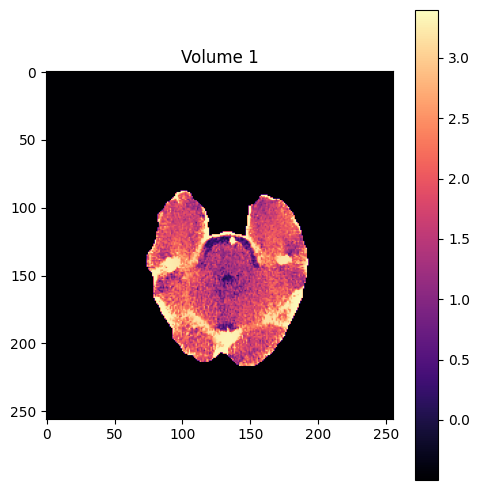

interactive(children=(IntSlider(value=0, description='Time:', max=17), IntSlider(value=0, description='Slice:'…

In [42]:
multi_vol_seq_interactive([v1])

## Dataset 1:
- load the data as 

In [43]:
class Dataset2D(Dataset):
    def __init__(
        self, data_paths, context_window=4, prediction_window=1, transform=None
    ):
        self.data_paths = data_paths
        self.context_window = context_window
        self.prediction_window = prediction_window
        self.transform = transform
        self.samples = []
        self.depth = None
        # For every path to a volume sequence in .npy
        for data_path in self.data_paths:
            volume_seq = np.load(data_path)
            # remember depth, all volumes need to have the same depth
            if self.depth == None or self.depth == volume_seq.shape[0]:
                self.depth = volume_seq.shape[0]
            else:
                print("The depths in one or more volumes are not the same!")
            # Convert to tensor
            volume_seq = torch.from_numpy(volume_seq)
            for h in range(volume_seq.shape[1]):
                # Generate samples
                for t in range(
                    len(volume_seq) - self.context_window - self.prediction_window + 1
                ):
                    # Input volume sequence (context_window x 1 x 256 x 256), target volume (1 x 1 x 256 x 256)
                    self.samples.append(
                        (
                            volume_seq[t : t + self.context_window, h].unsqueeze(1),
                            volume_seq[t+ self.context_window : t+ self.context_window+ self.prediction_window,h,].unsqueeze(1),
                        )
                    )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

class Dataset3D(Dataset):
    def __init__(self, data_paths, context_window=4, prediction_window=1, transform=None):
        self.data_paths = data_paths
        self.context_window = context_window
        self.prediction_window = prediction_window
        self.transform = transform
        self.samples = []
        # For every path to a volume sequence in .npy
        for data_path in self.data_paths:
            volume_seq = np.load(data_path)
            # Convert to tensor
            volume_seq = torch.from_numpy(volume_seq)

            for t in range(volume_seq.shape[0]-context_window-prediction_window+1):
                self.samples.append([volume_seq[t:t+context_window].unsqueeze(1), 
                                     volume_seq[t+context_window:t+context_window+prediction_window].unsqueeze(1)])
                # Input-shape: [T, C, D, H, W]
                # Target-shape: [T, C, D, H, W]
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

In [64]:
root = "../selected_volumes"
#root = "../QualityFiltered"
# Training parameters
batch_size = 4
sequence_length = 8
prediction_length=10
learning_rate = 1e-4
num_epochs = 100
# Data parameters
train_split = 0.8
val_split = 0.1


data_paths = [os.path.join(root, path) for path in os.listdir(root)]
dataset = Dataset2D(data_paths, context_window=4)
print(len(data_paths))
def get_data_loaders(batch_size=4, sequence_length=4, prediction_length=1, num_workers=0, pin_memory=False, drop_last=False):
    # Load all folder paths
    # Split into train/val/test
    n_train = int(len(data_paths) * train_split)
    n_val = int(len(data_paths) * val_split)
    train_paths = data_paths[:n_train]
    val_paths = data_paths[n_train:n_train+n_val]
    test_paths = data_paths[n_train+n_val:]
    
    # Create datasets
    train_dataset = Dataset2D(train_paths, sequence_length, prediction_length)
    val_dataset = Dataset2D(val_paths, sequence_length, prediction_length)
    test_dataset = Dataset2D(test_paths, sequence_length, prediction_length)

    val_dataset_3d = Dataset3D(val_paths, sequence_length, prediction_length)
    test_dataset_3d = Dataset3D(test_paths, sequence_length, prediction_length)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=drop_last)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=drop_last)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=drop_last)

    val_loader_3d = DataLoader(val_dataset_3d, batch_size=batch_size, drop_last=drop_last)
    test_loader_3d = DataLoader(test_dataset_3d, batch_size=batch_size, drop_last=drop_last)
    
    return train_loader, val_loader, test_loader, val_loader_3d, test_loader_3d, train_dataset, val_dataset, test_dataset, val_dataset_3d, test_dataset_3d

10


In [45]:
train_loader, val_loader, test_loader, val_loader_3d, test_loader_3d, train_dataset, val_dataset, test_dataset, val_dataset_3d, test_dataset_3d = get_data_loaders(
    batch_size=batch_size, 
    sequence_length=sequence_length,
    prediction_length=prediction_length,
)

In [46]:
for i, (input, target) in enumerate(train_loader):
    print(i, input.shape, target.shape)
    break


0 torch.Size([4, 8, 1, 256, 256]) torch.Size([4, 10, 1, 256, 256])


2Plus1D Unet

In [47]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, transpose=False, act_norm=False):
        super(BasicConv2d, self).__init__()
        self.act_norm=act_norm
        if not transpose:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,output_padding=stride //2 )
        self.norm = nn.GroupNorm(2, out_channels)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y


class ConvSC(nn.Module):
    def __init__(self, C_in, C_out, stride, transpose=False, act_norm=True):
        super(ConvSC, self).__init__()
        if stride == 1:
            transpose = False
        self.conv = BasicConv2d(C_in, C_out, kernel_size=3, stride=stride,
                                padding=1, transpose=transpose, act_norm=act_norm)

    def forward(self, x):
        y = self.conv(x)
        return y


class GroupConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups, act_norm=False):
        super(GroupConv2d, self).__init__()
        self.act_norm = act_norm
        if in_channels % groups != 0:
            groups = 1
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,groups=groups)
        self.norm = nn.GroupNorm(groups,out_channels)
        self.activate = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.activate(self.norm(y))
        return y


class Inception(nn.Module):
    def __init__(self, C_in, C_hid, C_out, incep_ker=[3,5,7,11], groups=8):        
        super(Inception, self).__init__()
        self.conv1 = nn.Conv2d(C_in, C_hid, kernel_size=1, stride=1, padding=0)
        layers = []
        for ker in incep_ker:
            layers.append(GroupConv2d(C_hid, C_out, kernel_size=ker, stride=1, padding=ker//2, groups=groups, act_norm=True))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        y = 0
        for layer in self.layers:
            y += layer(x)
        return y

def stride_generator(N, reverse=False):
    strides = [1, 2]*10
    if reverse: return list(reversed(strides[:N]))
    else: return strides[:N]

class Encoder(nn.Module):
    def __init__(self,C_in, C_hid, N_S):
        super(Encoder,self).__init__()
        strides = stride_generator(N_S)
        self.enc = nn.Sequential(
            ConvSC(C_in, C_hid, stride=strides[0]),
            *[ConvSC(C_hid, C_hid, stride=s) for s in strides[1:]]
        )
    
    def forward(self,x):# B*4, 3, 128, 128
        enc1 = self.enc[0](x)
        latent = enc1
        for i in range(1,len(self.enc)):
            latent = self.enc[i](latent)
        return latent,enc1


class Decoder(nn.Module):
    def __init__(self,C_hid, C_out, N_S):
        super(Decoder,self).__init__()
        strides = stride_generator(N_S, reverse=True)
        self.dec = nn.Sequential(
            *[ConvSC(C_hid, C_hid, stride=s, transpose=True) for s in strides[:-1]],
            ConvSC(2*C_hid, C_hid, stride=strides[-1], transpose=True)
        )
        self.readout = nn.Conv2d(C_hid, C_out, 1)
    
    def forward(self, hid, enc1=None):
        for i in range(0,len(self.dec)-1):
            hid = self.dec[i](hid)
        Y = self.dec[-1](torch.cat([hid, enc1], dim=1))
        Y = self.readout(Y)
        return Y

class Mid_Xnet(nn.Module):
    def __init__(self, channel_in, channel_hid, N_T, incep_ker = [3,5,7,11], groups=8):
        super(Mid_Xnet, self).__init__()

        self.N_T = N_T
        enc_layers = [Inception(channel_in, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            enc_layers.append(Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        enc_layers.append(Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))

        dec_layers = [Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            dec_layers.append(Inception(2*channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        dec_layers.append(Inception(2*channel_hid, channel_hid//2, channel_in, incep_ker= incep_ker, groups=groups))

        self.enc = nn.Sequential(*enc_layers)
        self.dec = nn.Sequential(*dec_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.reshape(B, T*C, H, W)

        # encoder
        skips = []
        z = x
        for i in range(self.N_T):
            z = self.enc[i](z)
            if i < self.N_T - 1:
                skips.append(z)

        # decoder
        z = self.dec[0](z)
        for i in range(1, self.N_T):
            z = self.dec[i](torch.cat([z, skips[-i]], dim=1))

        y = z.reshape(B, T, C, H, W)
        return y


class SimVP(nn.Module):
    def __init__(self, shape_in, hid_S=16, hid_T=256, N_S=4, N_T=8, incep_ker=[3,5,7,11], groups=8):
        super(SimVP, self).__init__()
        T, C, H, W = shape_in
        self.enc = Encoder(C, hid_S, N_S)
        self.hid = Mid_Xnet(T*hid_S, hid_T, N_T, incep_ker, groups)
        self.dec = Decoder(hid_S, C, N_S)


    def forward(self, x_raw):
        B, T, C, H, W = x_raw.shape
        x = x_raw.view(B*T, C, H, W)

        embed, skip = self.enc(x)
        _, C_, H_, W_ = embed.shape

        z = embed.view(B, T, C_, H_, W_)
        hid = self.hid(z)
        hid = hid.reshape(B*T, C_, H_, W_)

        Y = self.dec(hid, skip)
        Y = Y.reshape(B, T, C, H, W)
        return Y

In [48]:
#testing the model
#model = SimVP([8, 1, 256, 256]).to(device)
#x = torch.randn(4, 8, 1, 256, 256).to(device)
#out = model(x)
#print(out.shape)
#print(out[:, 7:8, :, :].shape)

In [67]:
x = torch.randn(2, 3)
y = torch.randn(1, 3)
x,y,torch.concat((x, y), dim=0)

(tensor([[ 0.5510, -0.1886, -2.0156],
         [-1.1170, -0.1994, -1.2933]]),
 tensor([[ 0.4649, -1.3946, -0.4587]]),
 tensor([[ 0.5510, -0.1886, -2.0156],
         [-1.1170, -0.1994, -1.2933],
         [ 0.4649, -1.3946, -0.4587]]))

In [54]:
for t in range(0, 10, 3):
    if 10-t<3:
        end = 10-t
    else:
        end = 3
    print(t, f"vorhersage: {t}:{t+end}", end)

0 vorhersage: 0:3 3
3 vorhersage: 3:6 3
6 vorhersage: 6:9 3
9 vorhersage: 9:10 1


In [55]:
class Pl_Model(pl.LightningModule):
    def __init__(
        self,
        passed_model: nn.Module,
        config: Dict[str, Any],
    ):
        super(Pl_Model, self).__init__()
        self.passed_model = passed_model
        self.config = config

        #speicher alle parameter ab
        self.save_hyperparameters(ignore=["passed_model"])

        # Setup training components
        self.mse_criterion = nn.MSELoss()
        self.huber_criterion = nn.HuberLoss(delta=1.0)
        self.ssim_criterion = StructuralSimilarityIndexMeasure()
        self.psnr_criterion = PeakSignalNoiseRatio()
        

    def forward(self, x):
        x = self.passed_model(x)
        return x

    def configure_optimizers(self):
        """Sets the Optimizer for the Model"""
        optimizer = optim.Adam(
            self.parameters(), 
            lr=config['learning_rate'],
        )
        return [optimizer]

    def _calculate_loss(self, batch, mode="train"):
        """Calculates the loss for a batch in different modes (training, validation, testing)"""
        inputs, targets = batch

        #forward pass
        mse_loss = 0.0
        huber_loss = 0.0
        rmse_loss = 0.0
        #ssim_loss = 0.0
        psnr_loss = 0.0
        total_loss = 0.0
        for t in range(0, self.config["pred_frames"], self.config["pred_n_frames_per_step"]):
            if self.config["pred_frames"]-t<self.config["pred_n_frames_per_step"]:
                frames_this_step = self.config["pred_frames"]-t
            else:
                frames_this_step = self.config["pred_n_frames_per_step"]
            outputs = self.forward(inputs)
            #print(f"{t}:{t+frames_this_step}")
            #get only the first predicted frame
            outputs = outputs[:, :frames_this_step, :, :]
            
            #calcualte losses
            mse_loss_ = self.mse_criterion(outputs, targets[:, t:t+frames_this_step, :, :])
            huber_loss_ = self.huber_criterion(outputs, targets[:, t:t+frames_this_step, :, :])
            rmse_loss_ = torch.sqrt(self.mse_criterion(outputs, targets[:, t:t+frames_this_step, :, :]))
            #ssim_loss_ = self.ssim_criterion(outputs, targets[:, t:t+frames_this_step, :, :])
            psnr_loss_ = self.psnr_criterion(outputs, targets[:, t:t+frames_this_step, :, :])
            total_loss_ = mse_loss_ + 0.5 * huber_loss_
            
            mse_loss += mse_loss_.item()
            huber_loss += huber_loss_.item()
            rmse_loss += rmse_loss_.item()
            #ssim_loss += ssim_loss_.item()
            psnr_loss += psnr_loss_.item()
            total_loss += total_loss_
            
            inputs = torch.cat([inputs[:, self.config["pred_n_frames_per_step"]:, :, :], outputs], dim=1)

        #logging
        self.log(f"{mode}_mse_loss", mse_loss)
        self.log(f"{mode}_huber_loss", huber_loss)
        self.log(f"{mode}_rmse_loss", rmse_loss)
        #self.log(f"{mode}_ssim_loss", ssim_loss)
        self.log(f"{mode}_psnr_loss", psnr_loss)
        self.log(f"{mode}_total_loss", total_loss)

        return total_loss, mse_loss, huber_loss

    def training_step(self, batch, batch_idx):
        loss, _, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx):
        if dataloader_idx==1:
            inputs, targets = batch
            # iterate over depth
            outputs = []
            for d in range(inputs.shape[3]):
                inputs_ = inputs[:, :, :, d, :, :]
                #iterate over time
                outputs_d = []
                for t in range(0, inputs.shape[1], self.config["pred_n_frames_per_step"]):
                    if inputs.shape[1]-t<self.config["pred_n_frames_per_step"]:
                        frames_this_step = inputs.shape[1]-t
                    else:
                        frames_this_step = self.config["pred_n_frames_per_step"]
                    
                    outputs_t = self.forward(inputs_)
            
                    #get only the first predicted frame
                    outputs_t = outputs_t[:, :frames_this_step, :, :]
            
                    #add to depth lst
                    outputs_d.append(outputs_t)
            
                    inputs_ = torch.cat([inputs_[:, self.config["pred_n_frames_per_step"]:, :, :], outputs_t], dim=1)
            
                #concat time and add to overall lst
                outputs_d = torch.concat(outputs_d, dim=1)
                outputs.append(outputs_d)
            #stack over depth
            outputs = torch.stack(outputs, dim=3)

            #calculate losses
            mse_loss = self.mse_criterion(outputs, targets)
            huber_loss = self.huber_criterion(outputs, targets)
            rmse_loss = torch.sqrt(self.mse_criterion(outputs, targets))
            #ssim_loss = self.ssim_criterion(outputs, targets)
            psnr_loss = self.psnr_criterion(outputs, targets)
            total_loss = mse_loss + 0.5 * huber_loss

            #logging
            self.log(f"overall_val_mse_loss", mse_loss)
            self.log(f"overall_val_huber_loss", huber_loss)
            self.log(f"overall_val_rmse_loss", rmse_loss)
            #self.log(f"overall_val_ssim_loss", ssim_loss)
            self.log(f"overall_val_psnr_loss", psnr_loss)
            self.log(f"overall_val_total_loss", total_loss)
                    
        else:
            _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

    def check_losses(self, loader, mode, use_wandb=False):
        mse_loss = 0.0
        huber_loss = 0.0
        rmse_loss = 0.0
        #ssim_loss = 0.0
        psnr_loss = 0.0
        total_loss = 0.0
        for inputs, targets in loader:
            for t in range(self.config["pred_frames"]):
                mse_loss_ = self.mse_criterion(inputs[:, -1, :, :, :].unsqueeze(1), targets[:, t, :, :].unsqueeze(1))
                huber_loss_ = self.huber_criterion(inputs[:, -1, :, :, :].unsqueeze(1), targets[:, t, :, :].unsqueeze(1))
                #ssim_loss_ = self.ssim_criterion(inputs[:, -1, :, :, :], targets[:, t, :, :].unsqueeze(1))
                rmse_loss_ = torch.sqrt(self.mse_criterion(inputs[:, -1, :, :, :].unsqueeze(1), targets[:, t, :, :].unsqueeze(1)))
                psnr_loss_ = self.psnr_criterion(inputs[:, -1, :, :, :].unsqueeze(1), targets[:, t, :, :].unsqueeze(1))
                total_loss_ = mse_loss_ + 0.5 * huber_loss_   
        
                mse_loss += mse_loss_.item()
                huber_loss += huber_loss_.item()
                rmse_loss += rmse_loss_.item()
                #ssim_loss += ssim_loss_.item()
                psnr_loss += psnr_loss_.item()
                total_loss += total_loss_.item()
                
        mse_loss = mse_loss / len(loader)
        huber_loss = huber_loss / len(loader)
        rmse_loss = rmse_loss / len(loader)
        #ssim_loss = ssim_loss / len(loader)
        psnr_loss = psnr_loss / len(loader)
        total_loss = total_loss / len(loader)

        if use_wandb:
            wandb.log({f"Checked_{mode}_mse_loss": mse_loss})
            wandb.log({f"Checked_{mode}_huber_loss": huber_loss})
            wandb.log({f"Checked_{mode}_rmse_loss": rmse_loss})
            #wandb.log({f"Checked_{mode}_ssim_loss": ssim_loss})
            wandb.log({f"Checked_{mode}_psnr_loss": psnr_loss})
            wandb.log({f"Checked_{mode}_total_loss": total_loss})
        
        return mse_loss, huber_loss, rmse_loss, psnr_loss, total_loss
        
    def log_predictions(self):
        """Log example predictions to wandb"""
        #needs to be added to other method
        if epoch % self.config['viz_interval'] == 0:
                self.log_predictions()
        #but this whole method needs to be rewritten
        self.model.eval()
        with torch.no_grad():
            # Get a batch of validation data
            data, target = next(iter(self.val_loader))
            data = data.to(self.device)
            target = target.to(self.device)
            
            # Generate predictions
            output = self.model(data)
            
            # Log images
            wandb.log({
                "predictions": wandb.Image(output[0, 0].cpu()),
                "targets": wandb.Image(target[0, 0].cpu()),
                "input_sequence": [wandb.Image(data[0, i].cpu()) for i in range(data.shape[1])]
            })

In [65]:
config = {
    #for the dataloaders
    'batch_size': 1,
    'learning_rate': 0.0005,
    "num_workers": 10,#0, wenn die gpu nicht benutzt wird
    "pin_memory": True,#False, wenn die gpu nicht benutzt wird
    "drop_last": False,
    'epochs': 40,
    #'log_interval': 20,
    #'viz_interval': 1,
    'run_name': '2D-SimpVP_v2',
    'input_frames': 8,
    "pred_frames": 10,
    "pred_n_frames_per_step": 3,
    'base_filters': 32,
}

# Initialize model
model = SimVP(
    shape_in=[config["input_frames"], 1, 256, 256]
)

# Get data loaders
train_loader, val_loader, test_loader, val_loader_3d, test_loader_3d, train_dataset, val_dataset, test_dataset, val_dataset_3d, test_dataset_3d = get_data_loaders(
    batch_size=config['batch_size'],
    num_workers=config["num_workers"],
    pin_memory=config["pin_memory"],
    drop_last=config["drop_last"],
    sequence_length=config["input_frames"], 
    prediction_length=config["pred_frames"],
)

wandb_logger = WandbLogger(entity="ChadCTP", project="perfusion-ct-prediction", name=config["run_name"])

# Initialize pl_model
pl_model = Pl_Model(
    passed_model=model,
    config=config,
)

# Initialize trainer
trainer = pl.Trainer(
    logger=wandb_logger,
    accelerator="gpu",
    devices= [2] if torch.cuda.is_available() else None,
    max_epochs=config["epochs"],
    callbacks=[RichProgressBar()],
    check_val_every_n_epoch=1,
)

wandb_logger.watch(pl_model)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [59]:

trainer.fit(
    pl_model,
    train_dataloaders=train_loader,
    val_dataloaders=[val_loader, val_loader_3d],
)

#check and log the losses "to beat"
pl_model.check_losses(train_loader, mode="train", use_wandb=True)
pl_model.check_losses(val_loader, mode="val", use_wandb=True)
pl_model.check_losses(test_loader, mode="test", use_wandb=True)

Epoch 0/39 ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13/128 0:00:03 • 0:00:32 3.60it/s v_num: egom

0:3

3:6

6:9

9:10

(0.49478906602598727,
 0.24403737107058987,
 2.197128993459046,
 248.17215943336487,
 0.6168077518232167)

In [18]:
val_results = trainer.validate(dataloaders=[val_loader, val_loader_3d])

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


ValueError: `.validate(ckpt_path="best")` is set but `ModelCheckpoint` is not configured to save the best model.

In [17]:
test_results = trainer.test(dataloaders=test_loader)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16/16 0:00:03 • 0:00:00 4.71it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_huber_loss      │    0.2334439754486084     │
│       test_mse_loss       │    0.4766775071620941     │
│      test_psnr_loss       │     249.0823516845703     │
│      test_rmse_loss       │    2.1639797687530518     │
│      test_total_loss      │    0.5933994650840759     │
└───────────────────────────┴───────────────────────────┘

In [19]:
save_load_path = f"../ModelWeights/{config['run_name']}.ckpt"
trainer.save_checkpoint(save_load_path)

wandb: 
wandb: 🚀 View run 2D-SimpVP_v2 at: https://wandb.ai/nbennewiz/perfusion-ct-prediction/runs/pgftsb4k


In [66]:
@torch.no_grad()
def overall_loss(model, loader, device):
    mse_loss = 0.0
    huber_loss = 0.0
    rmse_loss = 0.0
    #ssim_loss = 0.0
    psnr_loss = 0.0
    total_loss = 0.0
    model = model.to(device)
    for inputs, targets in loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        # iterate over depth
        outputs = []
        for d in range(inputs.shape[3]):
            inputs_ = inputs[:, :, :, d, :, :]
            #iterate over time
            outputs_d = []
            for t in range(0, model.config["pred_frames"], model.config["pred_n_frames_per_step"]):
                if model.config["pred_frames"]-t<model.config["pred_n_frames_per_step"]:
                    frames_this_step = model.config["pred_frames"]-t
                else:
                    frames_this_step = model.config["pred_n_frames_per_step"]
                
                outputs_t = model.forward(inputs_)
        
                #get only the first predicted frame
                outputs_t = outputs_t[:, :frames_this_step, :, :]

                #add to depth lst
                outputs_d.append(outputs_t)
        
                inputs_ = torch.cat([inputs_[:, model.config["pred_n_frames_per_step"]:, :, :], outputs_t], dim=1)
            #concat time and add to overall lst
            outputs_d = torch.concat(outputs_d, dim=1)
            outputs.append(outputs_d)
    
        #stack over depth
        outputs = torch.stack(outputs, dim=3)
        #print(outputs.shape)
        
        #calculate losses
        mse_loss += model.mse_criterion(outputs, targets).item()
        huber_loss += model.huber_criterion(outputs, targets).item()
        rmse_loss += torch.sqrt(model.mse_criterion(outputs, targets)).item()
        #ssim_loss = model.ssim_criterion(outputs, targets).item()
        psnr_loss += model.psnr_criterion(outputs, targets).item()
        total_loss += mse_loss + 0.5 * huber_loss

    mse_loss = mse_loss / len(loader)
    huber_loss = huber_loss / len(loader)
    rmse_loss = rmse_loss / len(loader)
    #ssim_loss = ssim_loss / len(loader)
    psnr_loss = psnr_loss / len(loader)
    total_loss = total_loss / len(loader)

    return outputs, mse_loss, huber_loss, rmse_loss, psnr_loss, total_loss

_, mse_loss, huber_loss, rmse_loss, psnr_loss, total_loss = overall_loss(model=pl_model, loader=test_loader_3d, device=device)
mse_loss, huber_loss, rmse_loss, psnr_loss, total_loss

(1.0721451044082642,
 0.3816462457180023,
 1.0354443788528442,
 11.258100509643555,
 1.2629682272672653)